## Importing Libraries and Data

In [1]:
# PredictCreditCardFraudML-DW.ipynb - Streamlined Version

# --- 1. IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- 2. DATA LOADING ---
df = pd.read_csv('data/creditcard.csv')
print("Data Loaded: ", df.shape)

Data Loaded:  (284807, 31)


In [3]:
# --- 3. DATA PREPROCESSING ---
X = df.drop('Class', axis=1)
y = df['Class']

In [4]:
# Standardize Amount and Time features
scaler = StandardScaler()
X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])

In [5]:
# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print("After SMOTE: ", X_res.shape, y_res.shape)

After SMOTE:  (568630, 30) (568630,)


In [6]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

In [9]:
# --- 4. MODEL TRAINING & EVALUATION FUNCTION ---
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85295
           1       0.97      0.92      0.95     85294

    accuracy                           0.95    170589
   macro avg       0.95      0.95      0.95    170589
weighted avg       0.95      0.95      0.95    170589

ROC AUC Score: 0.9893658355356391


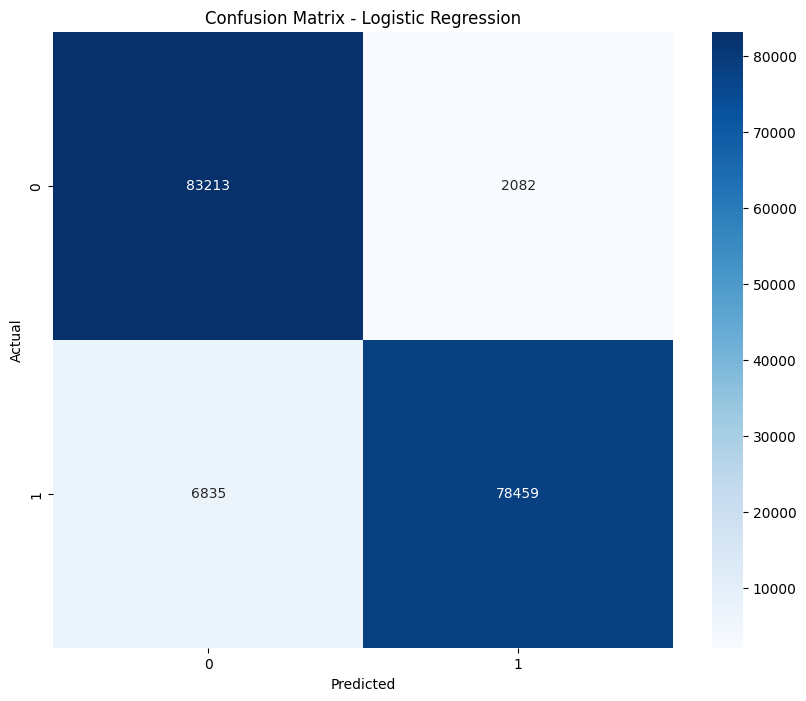


Model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00     85294

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

ROC AUC Score: 0.999654141508881


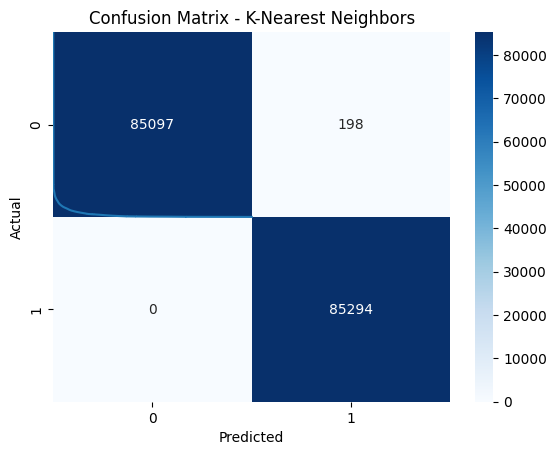


Model: Support Vector Machine
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     85295
           1       0.98      0.97      0.98     85294

    accuracy                           0.98    170589
   macro avg       0.98      0.98      0.98    170589
weighted avg       0.98      0.98      0.98    170589

ROC AUC Score: 0.9977240554404218


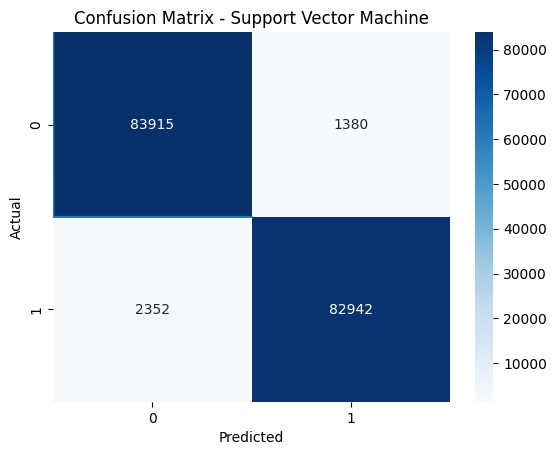


Model: Naive Bayes
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     85295
           1       0.97      0.85      0.91     85294

    accuracy                           0.91    170589
   macro avg       0.92      0.91      0.91    170589
weighted avg       0.92      0.91      0.91    170589

ROC AUC Score: 0.9504588366159065


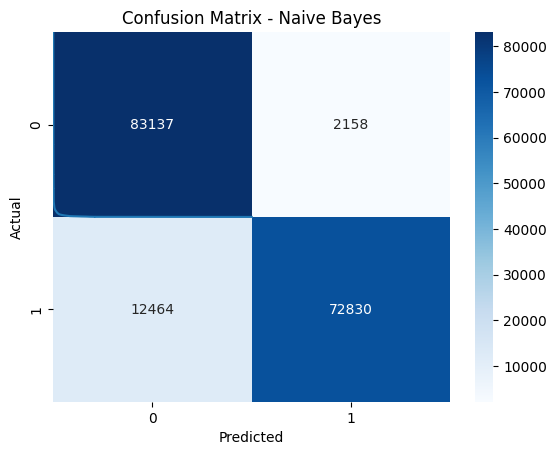


Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00     85294

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

ROC AUC Score: 0.9999995941665398


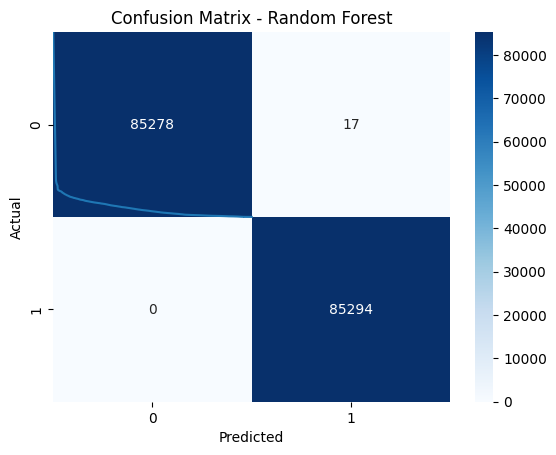


Model: XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00     85294

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

ROC AUC Score: 0.999995009657345


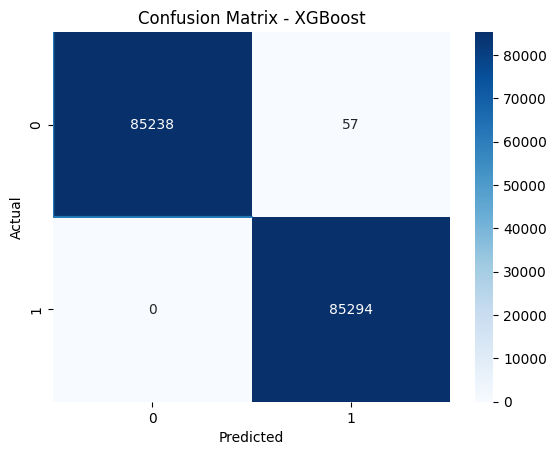

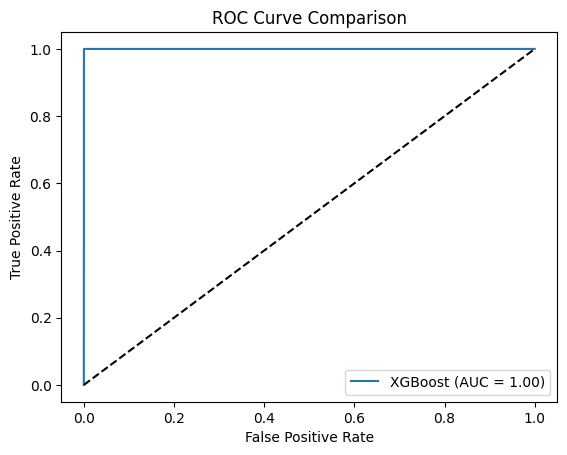

In [10]:
# --- 5. MODELS ---
models = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

plt.figure(figsize=(10, 8))
for name, model in models.items():
    evaluate_model(name, model, X_train, y_train, X_test, y_test)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [11]:
# --- 6. SAVE BEST MODEL (XGBoost) FOR LIVE SCORING ---
import joblib
best_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train, y_train)
joblib.dump(best_model, 'models/xgb_creditcard_fraud_model.pkl')

['models/xgb_creditcard_fraud_model.pkl']

In [12]:
# --- 7. LIVE SCORING SIMULATION ---
def simulate_live_transaction(transaction_df):
    model = joblib.load('models/xgb_creditcard_fraud_model.pkl')
    prediction = model.predict(transaction_df)
    prob = model.predict_proba(transaction_df)
    return prediction, prob

In [13]:
# Example live scoring
sample_transaction = X_test.sample(1)
pred, prob = simulate_live_transaction(sample_transaction)
print("Predicted Class:", pred[0])
print("Fraud Probability:", prob[0][1])

Predicted Class: 1
Fraud Probability: 0.9998807


In [14]:
# --- 8. SAVE FLAGGED TRANSACTIONS FOR DASHBOARD ---
y_pred_test = best_model.predict(X_test)
X_test_copy = X_test.copy()
X_test_copy['Actual_Class'] = y_test
X_test_copy['Predicted_Class'] = y_pred_test

In [15]:
# Save flagged fraud transactions
flagged_transactions = X_test_copy[X_test_copy['Predicted_Class'] == 1]
flagged_transactions.to_csv('dashboard/flagged_transactions.csv', index=False)
print("Flagged transactions saved for dashboard visualization.")

Flagged transactions saved for dashboard visualization.


#### Plot F1 Score Comparison

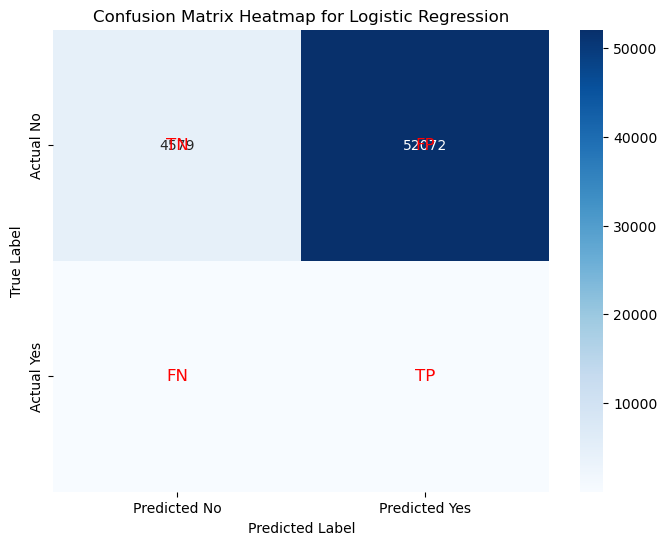

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion Matrices for the classifiers
confusion_matrices = {
    'Logistic Regression': [[4579, 52072], [1, 94]],
    'Decision Tree': [[56423, 228], [31, 64]],
    'Naive Bayes': [[55998, 653], [53, 42]],
    'MLP Classifier': [[56606, 45], [21, 74]],
    'Random Forest': [[84958, 18], [40, 102]],
    'SVM Classifier': [[56651, 0], [95, 0]],
    'XGBoost': [[56630, 23], [13, 80]]
}

# Function to plot confusion matrix heatmap with clear annotations for each category
def plot_confusion_heatmap(confusion_matrix, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted No', 'Predicted Yes'], 
                yticklabels=['Actual No', 'Actual Yes'])
    
    # Adding specific annotations to identify TP, TN, FP, FN
    plt.text(0.5, 0.5, 'TN', ha='center', va='center', fontsize=12, color='red')
    plt.text(1.5, 0.5, 'FP', ha='center', va='center', fontsize=12, color='red')
    plt.text(0.5, 1.5, 'FN', ha='center', va='center', fontsize=12, color='red')
    plt.text(1.5, 1.5, 'TP', ha='center', va='center', fontsize=12, color='red')
    
    plt.title(f'Confusion Matrix Heatmap for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot each confusion matrix in separate cells
# Logistic Regression
plot_confusion_heatmap(confusion_matrices['Logistic Regression'], 'Logistic Regression')



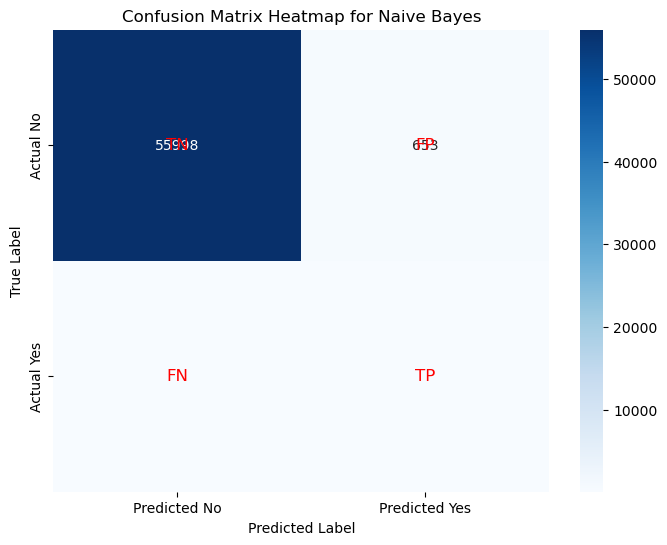

In [106]:
# Naive Bayes
plot_confusion_heatmap(confusion_matrices['Naive Bayes'], 'Naive Bayes')

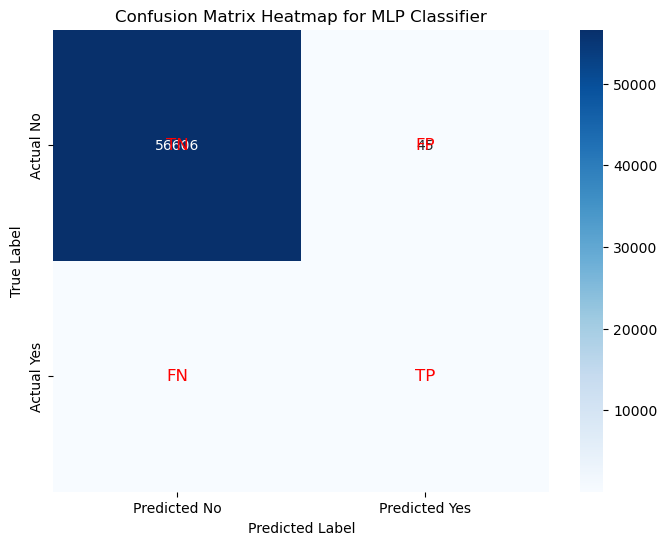

In [107]:
# MLP Classifier
plot_confusion_heatmap(confusion_matrices['MLP Classifier'], 'MLP Classifier')

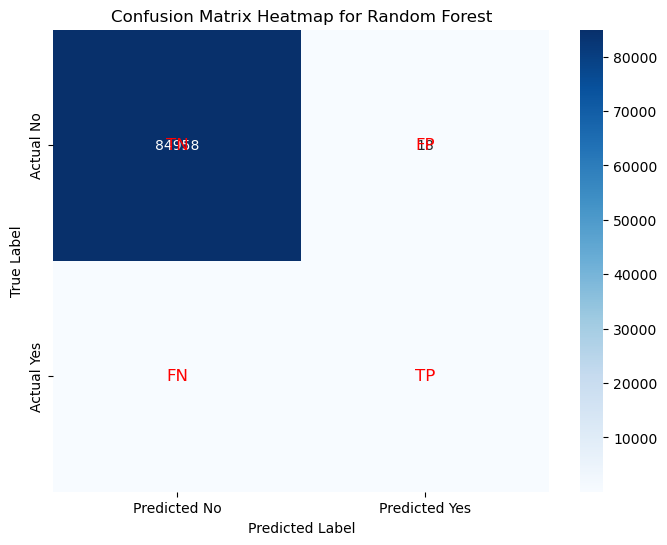

In [108]:
# Random Forest
plot_confusion_heatmap(confusion_matrices['Random Forest'], 'Random Forest')


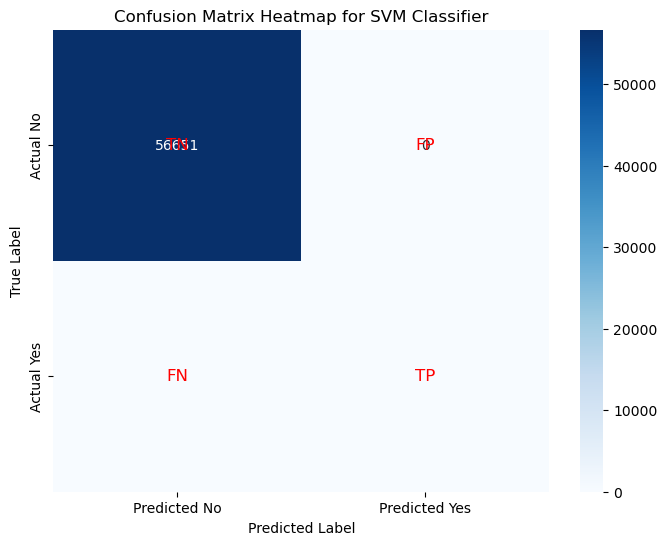

In [109]:
# SVM Classifier
plot_confusion_heatmap(confusion_matrices['SVM Classifier'], 'SVM Classifier')

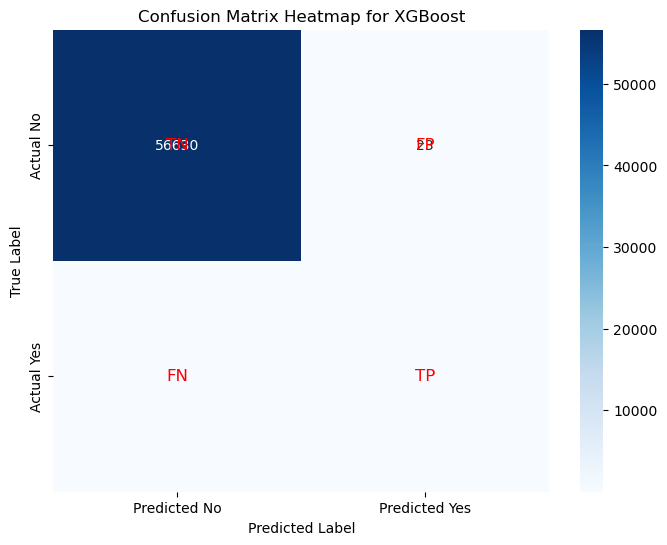

In [110]:
# XGBoost
plot_confusion_heatmap(confusion_matrices['XGBoost'], 'XGBoost')

In [ ]:
# # Plot F1 Score with percentages and different colors for each classifier
# plt.figure(figsize=(12, 6))
# bars = plt.barh(range(len(Prediction_f1_score)), list(Prediction_f1_score.values()), align='center', color=colors)
# plt.yticks(range(len(Prediction_f1_score)), list(Prediction_f1_score.keys()))
# plt.xlabel('F1 Score')
# plt.title('F1 Score Comparison')

# # Add percentage labels on bars
# for bar in bars:
#     plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2%}',
#              va='center', ha='left', fontsize=12, color='black')

# # Add a legend
# plt.legend(bars, Prediction_f1_score.keys(), loc='lower right')
# plt.show()

#### Plot AUC Score Comparison

In [ ]:
# # Plot AUC Score with percentages and different colors for each classifier
# plt.figure(figsize=(12, 6))
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Customize colors
# bars = plt.barh(range(len(Prediction_AUC)), list(Prediction_AUC.values()), align='center', color=colors)
# plt.yticks(range(len(Prediction_AUC)), list(Prediction_AUC.keys()))
# plt.xlabel('AUC Score')
# plt.title('AUC Score Comparison')

# # Add percentage labels on bars
# for bar in bars:
#     plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2%}',
#              va='center', ha='left', fontsize=12, color='black')

# # Add a legend
# plt.legend(bars, Prediction_AUC.keys(), loc='lower right')
# plt.show()

#### Display Metrics in Tabular Format

In [ ]:
# # Display the metrics in tabular format
# import pandas as pd

# metrics_df = pd.DataFrame({
#     'Accuracy': Prediction_Accuracy,
#     'Recall': Prediction_Recall,
#     'AUC Score': Prediction_AUC,
#     'F1 Score': Prediction_f1_score
# }).T

# print("\nSummary of Metrics for All Models:")
# print(metrics_df)

### Prediction Scores

In [ ]:
# from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score,precision_score,f1_score,classification_report
# import seaborn as sns
# from matplotlib import pyplot

# lr_accuracy = accuracy_score(Y_test, lr_predict)
# lr_recall = recall_score(Y_test, lr_predict)
# lr_cm = confusion_matrix(Y_test, lr_predict)
# lr_auc = roc_auc_score(Y_test, lr_predict)
# lr_precision = precision_score(Y_test, lr_predict)
# lr_f1 = f1_score(Y_test, lr_predict)
# lr_cl = classification_report(Y_test, lr_predict)

# print("Accuracy of Logistic Regression: {:.4%}".format(lr_accuracy))
# print("Recall: ",(lr_recall))
# print("ROC AUC: ",(lr_auc))
# print("precision score: ",(lr_precision))
# print("f1 score: ",(lr_f1))
# print("confusion matrix:\n",(lr_cm))
# print("classification report:\n",(lr_cl))

# lr_cm = pd.DataFrame(lr_cm, ['True Normal','True Fraud'],['Prediction Normal','Prediction Fraud'])
# pyplot.figure(figsize = (8,4))
# sns.set(font_scale=1.4)
# sns.heatmap(lr_cm, annot=True,annot_kws={"size": 16},fmt='g')

## Random Forest Classifier

In [ ]:
# from imblearn.over_sampling import ADASYN
# sampler = ADASYN(random_state = 0, n_jobs = -1)
# model_train_rf , model_test_rf = sampler.fit_resample(model_train, model_test)

### Shuffle Splitting the data into training and testing

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit

# sss = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=0)

In [ ]:
# for train_index, test_index in sss.split(model_train_rf, model_test_rf):
#     X_train, X_test = model_train_rf[train_index], model_train_rf[test_index]
#     Y_train, Y_test = model_test_rf[train_index], model_test_rf[test_index]

### Building Supervised Model

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(n_estimators= 200, criterion = 'entropy', random_state = 0, n_jobs = -1)
# rf.fit(X_train, Y_train)

In [ ]:
# rf_predict = rf.predict(X_test)

### Prediction Scores

In [ ]:
# rf_accuracy = accuracy_score(Y_test, rf_predict)
# rf_recall = recall_score(Y_test, rf_predict)
# rf_cm = confusion_matrix(Y_test, rf_predict)
# rf_auc = roc_auc_score(Y_test, rf_predict)
# rf_precision = precision_score(Y_test, rf_predict)
# rf_f1 = f1_score(Y_test, rf_predict)
# rf_cl = classification_report(Y_test, rf_predict)

# print("Accuracy of Random Forest: {:.4%}".format(rf_accuracy))
# print("Recall: ",(rf_recall))
# print("ROC AUC: ",(rf_auc))
# print("precision score: ",(rf_precision))
# print("f1 score: ",(rf_f1))
# print("confusion matrix:\n",(rf_cm))
# print("classification report:\n",(rf_cl))

# rf_cm = pd.DataFrame(rf_cm, ['True Normal','True Fraud'],['Prediction Normal','Prediction Fraud'])
# pyplot.figure(figsize = (8,4))
# sns.set(font_scale=1.4)
# sns.heatmap(rf_cm, annot=True,annot_kws={"size": 16},fmt='g')

## K-Means Clustering

In [ ]:
# from imblearn.over_sampling import ADASYN
# under_sampler = ADASYN(random_state = 0, n_jobs = -1)
# model_train_km , model_test_km = sampler.fit_resample(model_train, model_test)

### Optimal Clusters

In [ ]:
# from sklearn.cluster import KMeans
# wcss = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters = i, max_iter = 200, random_state = 0)
#     kmeans.fit(model_train_km)
#     wcss.append(kmeans.inertia_)
# plt.plot(range(1, 11), wcss)
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

### Unsupervised Clustering

In [ ]:
# kmeans = KMeans(n_clusters = 2, max_iter = 200, random_state = 0).fit(model_train_km)

In [ ]:
# centers = kmeans.cluster_centers_

In [ ]:
# from scipy import spatial
# distance = pd.DataFrame(spatial.distance.cdist(model_train_km, centers, 'euclidean'))
# distance['distance_mean'] = distance.apply(np.mean, axis=1)
# distance.head()

In [ ]:
# out_per = np.percentile(distance['distance_mean'], 95)

In [ ]:
# model_predict_km = np.where(distance['distance_mean'] >= out_per, 1, 0)

### Prediction Scores

In [ ]:
# km_accuracy = accuracy_score(model_test_km, model_predict_km)
# km_recall = recall_score(model_test_km, model_predict_km)
# km_cm = confusion_matrix(model_test_km, model_predict_km)
# km_auc = roc_auc_score(model_test_km, model_predict_km)
# km_precision = precision_score(model_test_km, model_predict_km)
# km_f1 = f1_score(model_test_km, model_predict_km)
# km_cl = classification_report(model_test_km, model_predict_km)

# print("Accuracy of K-means: {:.4%}".format(km_accuracy))
# print("Recall: ",(km_recall))
# print("ROC AUC: ",(km_auc))
# print("precision score: ",(km_precision))
# print("f1 score: ",(km_f1))
# print("confusion matrix:\n",(km_cm))
# print("classification report:\n",(km_cl))

# km_cm = pd.DataFrame(km_cm, ['True Normal','True Fraud'],['Prediction Normal','Prediction Fraud'])
# pyplot.figure(figsize = (8,4))
# sns.set(font_scale=1.4)
# sns.heatmap(km_cm, annot=True,annot_kws={"size": 16},fmt='g')

In [ ]:
# Prediction_Accuracy={
#     'Logistic Regression': lr_accuracy,
#     'Random Forest': rf_accuracy,
#     'K-Means': km_accuracy
# }

# Prediction_Recall={
#     'Logistic Regression': lr_recall,
#     'Random Forest': rf_recall,
#     'K-Means': km_recall
# }

# Prediction_AUC={
#     'Logistic Regression': lr_auc,
#     'Random Forest': rf_auc,
#     'K-Means': km_auc
# }

# Prediction_f1_score={
#     'Logistic Regression': lr_f1,
#     'Random Forest': rf_f1,
#     'K-Means': km_f1
# }

In [ ]:
# pyplot.title('Accuracy')
# pyplot.barh(range(len(Prediction_Accuracy)), list(Prediction_Accuracy.values()), align='center')
# pyplot.yticks(range(len(Prediction_Accuracy)), list(Prediction_Accuracy.keys()))
# pyplot.xlabel('Accuracy Score')

In [ ]:
# pyplot.title('Recall')
# pyplot.barh(range(len(Prediction_Recall)), list(Prediction_Recall.values()), align='center')
# pyplot.yticks(range(len(Prediction_Recall)), list(Prediction_Recall.keys()))
# pyplot.xlabel('Recall Score')

In [ ]:
# pyplot.title('AUC Score')
# pyplot.barh(range(len(Prediction_AUC)), list(Prediction_AUC.values()), align='center')
# pyplot.yticks(range(len(Prediction_AUC)), list(Prediction_AUC.keys()))
# pyplot.xlabel('AUC Score')

In [ ]:
# pyplot.title('f1 Score')
# pyplot.barh(range(len(Prediction_f1_score)), list(Prediction_f1_score.values()), align='center')
# pyplot.yticks(range(len(Prediction_f1_score)), list(Prediction_f1_score.keys()))
# pyplot.xlabel('f1 Score')

In [ ]:
# rf_accuracy = accuracy_score(Y_test, rf_predict)
# print("Accuracy of Random Forest: {:.4%}".format(rf_accuracy))
# km_accuracy = accuracy_score(model_test_km, model_predict_km)
# print("Accuracy of K-means: {:.4%}".format(km_accuracy))